#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 20

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.32941078, -0.91572001, -0.23009869],
       [ 0.25947521,  0.32211454, -0.9104476 ],
       [ 0.90783322,  0.24020635,  0.34371465]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001400


In [33]:
Ret.shape

(20, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000169


In [37]:
C1(dx,dy,dz,Ret)

array([[ 7.62612844e-01, -4.55113555e-01, -1.38197141e-02,
        -2.61128545e-01,  2.99138014e-03,  8.53121495e-04,
        -1.89290346e+00, -2.76146248e+00, -1.40030672e+00,
         2.67824173e-01, -2.98350530e+00, -1.21498529e+00,
         3.97245483e-02,  1.17135578e+00, -1.81592906e+00,
        -3.25467166e+00,  2.24338447e-02,  1.17276837e-01,
         1.20101761e+00,  1.71523978e-01],
       [-1.53889722e+00, -7.77885314e-01, -7.85044882e-01,
        -4.22584263e-02,  2.35174279e+00,  2.26910572e+00,
         7.94691974e-02, -1.44389482e-01, -6.93652235e-02,
        -1.99098872e+00,  6.29639081e-01,  1.82564787e+00,
         1.66291171e-01, -2.32276761e+00, -1.38045848e-01,
        -7.02510734e+00, -5.04152908e-01, -1.03962819e+00,
        -2.13437840e+00,  2.16262204e-01],
       [ 1.02684198e+00, -1.78722130e-01, -1.92403039e+00,
        -1.55882833e-02, -8.59075185e-01, -2.88154599e+00,
        -5.37691686e-01, -4.56644863e-02, -2.23867932e+00,
        -2.36782096e+00, -2.3

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 4.37666099e+03, -8.83178340e+03,  5.89308099e+03],
       [-2.61191214e+03, -4.46431022e+03, -1.02569237e+03],
       [-7.93118079e+01, -4.50539922e+03, -1.10420757e+04],
       [-1.49862558e+03, -2.42522543e+02, -8.94616871e+01],
       [ 1.71676321e+01,  1.34967317e+04, -4.93026164e+03],
       [ 4.89609321e+00,  1.30224747e+04, -1.65372902e+04],
       [-1.08634372e+04,  4.56076421e+02, -3.08583083e+03],
       [-1.58481269e+04, -8.28656140e+02, -2.62070036e+02],
       [-8.03640782e+03, -3.98089372e+02, -1.28478566e+04],
       [ 1.53705202e+03, -1.14263519e+04, -1.35890049e+04],
       [-1.71224382e+04,  3.61352006e+03, -1.37124942e+03],
       [-6.97284183e+03,  1.04774551e+04, -1.93681959e+04],
       [ 2.27980531e+02,  9.54350671e+02, -1.40854095e+04],
       [ 6.72245060e+03, -1.33304422e+04, -4.81063114e+03],
       [-1.04216785e+04, -7.92249805e+02,  2.23858672e+03],
       [-1.86786711e+04, -4.03173294e+04, -3.31651342e+03],
       [ 1.28748596e+02, -2.89335065e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000361


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000243


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000029


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-1.11985462, -0.42552966,  0.71247705],
       [-0.28605675,  1.48438393,  0.24448692],
       [-0.63857712,  0.87509036, -0.29825053],
       [-0.55918215,  0.7643056 , -1.2557171 ],
       [-0.72634469, -0.83363038,  0.48405543],
       [-0.43491717, -1.66526187,  1.20302427],
       [-0.1921255 , -0.37900083, -0.20810271],
       [ 0.1814172 , -1.57690364,  0.62088359],
       [ 0.7561354 , -1.59568553,  0.22102069],
       [-0.15077604,  0.33639092,  0.08213357],
       [ 2.00334016, -1.37845222, -0.17533514],
       [ 1.33320772,  0.53868148, -0.90641469],
       [ 3.75208857,  0.54396258, -0.68992136],
       [-1.25190447,  1.29729389, -0.74645942],
       [-0.89231277, -0.52510298, -0.36088259],
       [ 1.50544031,  1.08852027,  2.1779815 ],
       [ 0.88101134,  0.14005867,  0.68518817],
       [-0.4069444 ,  0.44682595, -0.9572456 ],
       [ 1.90312904, -1.13588833,  0.71397073],
       [ 0.57712509, -1.08679017,  0.36626004]])

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000243


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000404


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000622


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.76401836,  0.76979367, -0.93701104],
       [ 0.7949154 , -1.20730678,  0.8696843 ],
       [ 1.13291263, -0.22395561, -0.15227984],
       [ 0.54086531,  1.17718006, -0.96480548],
       [ 0.25627487,  1.4949766 ,  0.07073163],
       [ 2.89076377, -0.66372831,  0.69263671],
       [ 1.15004991,  1.54577481,  0.83393019],
       [-0.70512976,  3.05308973, -0.43665146],
       [ 0.14151075,  1.68835412, -1.37445702],
       [ 0.28657593, -0.73139698,  0.22478885],
       [ 0.41149371,  0.88939175,  0.79814177],
       [ 0.75059347,  2.37814977,  0.92649549],
       [ 0.05345426,  1.50947667, -1.35362578],
       [ 1.32413916,  0.51263103, -0.28764658],
       [-0.47125662,  1.21125897,  2.12847893],
       [-0.32864756,  0.3128735 ,  1.20022461],
       [-0.03212642,  0.59566927,  0.34428028],
       [-1.41131811, -2.54345346, -0.21621821],
       [-0.42318632, -2.15178422,  0.97077845],
       [ 0.32539783, -0.19171013, -1.3016013 ]])

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 0.01022178, -0.01108379, -0.01051643, -0.01814375,  0.01181793,
         0.02573258,  0.00151862,  0.01970158,  0.01627024, -0.00227121,
         0.01075823, -0.0129802 , -0.01107867, -0.01832959,  0.0014509 ,
         0.00986368,  0.00491437, -0.0126157 ,  0.01659263,  0.01302325],
       [-0.08133724, -0.02703188,  0.02413825,  0.12068594, -0.05495175,
        -0.12430843,  0.0191105 , -0.06052343, -0.01535588, -0.0095705 ,
         0.0354791 ,  0.10265875,  0.10263688,  0.06351249,  0.02813656,
        -0.20453094, -0.0606989 ,  0.09217304, -0.05443237, -0.0314956 ],
       [-0.03251262,  0.15115365,  0.09333999,  0.08153636, -0.0769035 ,
        -0.16276857, -0.03620645, -0.15947244, -0.16652582,  0.03502812,
        -0.15600888,  0.04191796,  0.02067261,  0.14112121, -0.04452762,
         0.09540342,  0.00608853,  0.048388  , -0.13082751, -0.1139768 ]])

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000588


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-9.69499122e-08, -7.79696067e-08, -1.53881532e-07,
        -1.46108924e-06,  1.86436416e-06, -3.50234447e-06,
        -7.79627515e-08, -1.10707932e-07, -8.17740247e-07,
        -1.84397152e-07, -3.31151514e-06,  8.09814323e-08,
        -5.43061887e-06, -7.24822703e-07,  1.37819646e-06,
        -3.57497934e-06, -8.66323891e-07, -5.92679740e-08,
         3.75518390e-07,  4.31827433e-08],
       [-9.65613990e-03, -2.83259353e-03, -5.99945155e-03,
        -5.37091954e-04, -6.66377031e-03,  1.36727552e-02,
         3.54654637e-03,  1.00904101e-02,  9.33499649e-03,
        -1.15036675e-03,  9.47586491e-03,  8.13635127e-03,
         2.53701808e-02, -1.05834998e-02, -1.03146269e-02,
         3.67275872e-03,  4.43337463e-03,  2.64729643e-04,
        -9.18088600e-03,  6.66892715e-03],
       [ 1.06359707e-02,  3.62034863e-03,  7.55419299e-03,
         1.52963418e-02, -1.21688043e-02,  2.17055556e-02,
        -2.75918378e-03, -8.97260302e-03, -1.07504986e-03,
         3.01311662e-03,  2.3

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-4.37666099e+03,  2.61191214e+03,  7.93118079e+01,
         1.49862558e+03, -1.71676321e+01, -4.89609321e+00,
         1.08634372e+04,  1.58481269e+04,  8.03640782e+03,
        -1.53705202e+03,  1.71224382e+04,  6.97284183e+03,
        -2.27980531e+02, -6.72245060e+03,  1.04216785e+04,
         1.86786711e+04, -1.28748596e+02, -6.73055750e+02,
        -6.89268083e+03, -9.84381932e+02],
       [ 8.83178340e+03,  4.46431022e+03,  4.50539922e+03,
         2.42522543e+02, -1.34967317e+04, -1.30224747e+04,
        -4.56076421e+02,  8.28656140e+02,  3.98089372e+02,
         1.14263519e+04, -3.61352006e+03, -1.04774551e+04,
        -9.54350671e+02,  1.33304422e+04,  7.92249805e+02,
         4.03173294e+04,  2.89335065e+03,  5.96646144e+03,
         1.22492701e+04, -1.24113613e+03],
       [-6.02124553e+03,  8.97527825e+02,  1.09139112e+04,
        -3.87028551e+01,  4.80209710e+03,  1.64091257e+04,
         2.95766629e+03,  1.33905494e+02,  1.27196921e+04,
         1.34608403e+04,  1.2

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000804


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 3.10848109e+02, -3.46598326e+06,  3.26120426e+05],
       [-7.75394040e+01,  1.05493977e+06, -2.71727364e+05],
       [-3.60481933e+00,  3.95999848e+05, -3.59605760e+05],
       [ 3.86024234e+01, -6.25786373e+05,  2.35874922e+05],
       [ 2.50050245e+02, -7.41603389e+04, -2.45172353e+06],
       [-6.95578496e+02,  3.75024288e+06,  3.27596735e+06],
       [ 4.74465055e+01, -3.50682032e+05, -1.28582034e+05],
       [ 2.97664631e+02, -6.82572668e+05, -2.32425805e+06],
       [ 2.08414965e+02, -2.11331598e+06,  8.11508608e+03],
       [-3.35684108e+02,  3.15336341e+06,  2.37396619e+05],
       [ 5.65994460e+02, -2.85004633e+06, -2.86721376e+06],
       [ 4.05347825e+01, -3.20795391e+05, -8.86512798e+04],
       [ 3.12222398e-03, -5.73213923e+02,  5.41703762e+02],
       [ 1.93054077e+01, -2.30293878e+05,  3.52915811e+04],
       [ 4.11689904e+01, -1.88547932e+05, -2.27311905e+05],
       [ 3.20035818e+02, -2.43411933e+06, -7.98605623e+05],
       [ 6.26265341e+02, -3.83367370e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-3.17739743e+07,  3.26088969e+07,  3.46595181e+08],
       [-3.57449781e+07, -2.71762752e+07, -1.05497515e+08],
       [-7.74281722e+08, -3.60372299e+07, -3.96766348e+07],
       [-5.50542205e+07,  2.35820419e+07,  6.25731872e+07],
       [-3.87239553e+05, -2.45172391e+08,  7.41599556e+06],
       [-1.94846325e+08,  3.27577445e+08, -3.75043577e+08],
       [ 8.09465130e+06, -1.28574021e+07,  3.50690045e+07],
       [ 5.40826475e+08, -2.32372263e+08,  6.83108059e+07],
       [ 6.44098416e+07,  8.17885184e+05,  2.11337975e+08],
       [-4.11752577e+08,  2.36988984e+07, -3.15377102e+08],
       [-5.20944832e+07, -2.86726533e+08,  2.84999475e+08],
       [ 3.74241421e+08, -8.82807807e+06,  3.21165871e+07],
       [-2.30131419e+05,  5.41475932e+04,  5.72986104e+04],
       [-6.55073136e+08,  3.46430585e+06,  2.29645388e+07],
       [-4.32619698e+07, -2.27354734e+07,  1.88505105e+07],
       [-3.09580912e+07, -7.98636272e+07,  2.43408869e+08],
       [-5.02306281e+08, -2.49286135e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000219


In [76]:
Re_b(Ret).shape

(20, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000632


In [82]:
d_me_

array([[ 5.24185124e-02, -4.74644784e+02, -5.48378286e+01],
       [ 1.40950678e-03, -9.53153182e+00, -4.70614649e+00],
       [ 6.02983962e-03,  6.60902286e+02, -7.21846325e+02],
       [-1.23262189e-02,  7.63673750e+01,  4.81423055e+01],
       [-9.04688952e-02, -2.42868492e+00,  9.16302187e+02],
       [ 2.20554199e-02, -3.98311138e+02,  1.75538051e+02],
       [ 1.42436185e-02, -1.17342610e+02, -2.65336451e+01],
       [ 2.56752874e-02, -3.07542502e+00, -2.56283855e+02],
       [ 3.53197170e-02, -1.98871646e+02, -1.57901113e+02],
       [-3.90331523e-02,  7.79113847e+01,  3.16378847e+02],
       [ 1.73477168e-02, -4.10260901e+02,  2.35043379e+02],
       [-8.44742557e-03,  4.68324708e+02, -3.83016600e+02],
       [-4.49828351e-03,  3.66103830e+00,  4.17782783e+01],
       [ 4.77125963e-04,  7.01456311e+02, -7.06311555e+02],
       [-2.94397727e-02,  1.01891585e+02,  1.95489713e+02],
       [ 8.19163908e-02, -8.14232665e+02, -1.32061550e+01],
       [-1.72355255e-02, -7.45850489e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-4.37666099e+03,  2.61191214e+03,  7.93118079e+01,
         1.49862558e+03, -1.71676321e+01, -4.89609321e+00,
         1.08634372e+04,  1.58481269e+04,  8.03640782e+03,
        -1.53705202e+03,  1.71224382e+04,  6.97284183e+03,
        -2.27980531e+02, -6.72245060e+03,  1.04216785e+04,
         1.86786711e+04, -1.28748596e+02, -6.73055750e+02,
        -6.89268083e+03, -9.84381932e+02],
       [ 8.83178340e+03,  4.46431022e+03,  4.50539922e+03,
         2.42522543e+02, -1.34967317e+04, -1.30224747e+04,
        -4.56076421e+02,  8.28656140e+02,  3.98089372e+02,
         1.14263519e+04, -3.61352006e+03, -1.04774551e+04,
        -9.54350671e+02,  1.33304422e+04,  7.92249805e+02,
         4.03173294e+04,  2.89335065e+03,  5.96646144e+03,
         1.22492701e+04, -1.24113613e+03],
       [-6.02124553e+03,  8.97527825e+02,  1.09139112e+04,
        -3.87028551e+01,  4.80209710e+03,  1.64091257e+04,
         2.95766629e+03,  1.33905494e+02,  1.27196921e+04,
         1.34608403e+04,  1.2

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617, 3150635.90893617])

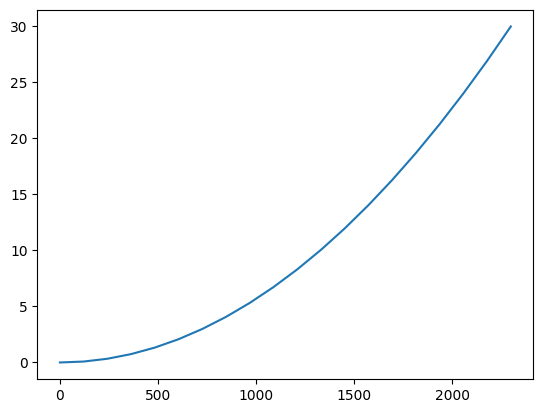

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [ 0.000e+00  1.210e+02 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 491
    fjac: [[ 0.000e+00  0.000e+00 ... -4.199e-17 -3.987e-17]
           [ 0.000e+00  0.000e+00 ...  1.091e-16  1.036e-16]
           ...
           [ 0.000e+00  0.000e+00 ...  3.547e-11 -3.736e-11]
           [ 0.000e+00  0.000e+00 ... -1.366e-13  1.012e-13]]
       r: [-4.698e+02 -4.698e+02 ...  0.000e+00 -0.000e+00]
     qtf: [-1.066e-01 -1.486e+00 ...  0.000e+00  0.000e+00]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [105]:
q0=root_.x

In [106]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

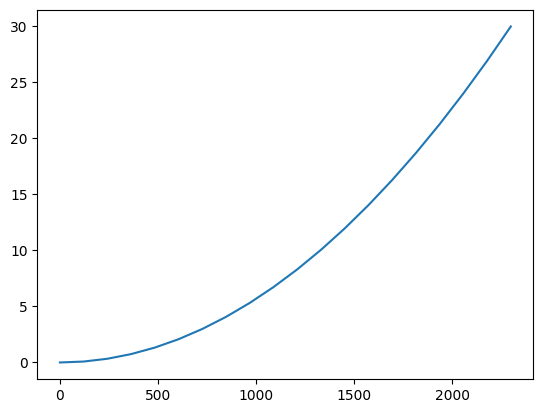

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
        
#     print(vessel_movement)
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    
#     return glob_force
#     print(glob_force)
#     print(np.linalg.inv(K)@glob_force)

    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [113]:
-0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4

(-7.05e-06, -7e-08, 1.418e-05, 1.45e-06, 1.75e-06, 1.14e-06)

In [114]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [115]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [116]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [117]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [118]:
fors

array([[-1.51083061e+03,  1.27142468e+01, -1.69792205e+01],
       [ 5.84986992e-09, -4.59340299e-08, -5.99316081e-08],
       [ 6.15400495e-08, -3.87467480e-08,  4.73069122e-08],
       [ 9.82254278e-09,  1.83912481e-08,  4.18613126e-08],
       [-1.38301402e-07, -1.40273187e-07, -1.32263267e-07],
       [ 1.31782144e-07, -4.46525519e-08,  1.08171662e-07],
       [ 6.70552254e-08,  1.39800250e-07,  5.44678187e-08],
       [-9.91858542e-08, -6.34736654e-08,  4.33938112e-08],
       [-2.42143869e-08,  1.59488991e-08,  1.30923581e-07],
       [ 1.04308128e-07,  8.30623321e-08, -7.71833584e-08],
       [-1.15483999e-07, -3.30473995e-08,  9.12114047e-08],
       [ 0.00000000e+00, -1.17653012e-08, -6.73462637e-08],
       [-1.00582838e-07, -4.66825441e-08, -1.35041773e-08],
       [-1.49011612e-08, -1.57160684e-09, -1.69966370e-08],
       [ 2.53319740e-07,  6.69388101e-10,  8.61473382e-09],
       [-1.55808283e-07,  2.04380501e-09, -2.68851692e-09],
       [-7.43316715e-08,  4.54927527e-09

### Vessle Simulation

In [119]:
sampleTime = 0.001              # sample time [seconds]
N = 100000                      # number of samples

In [120]:
N*sampleTime

100.0

In [121]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [122]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [123]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

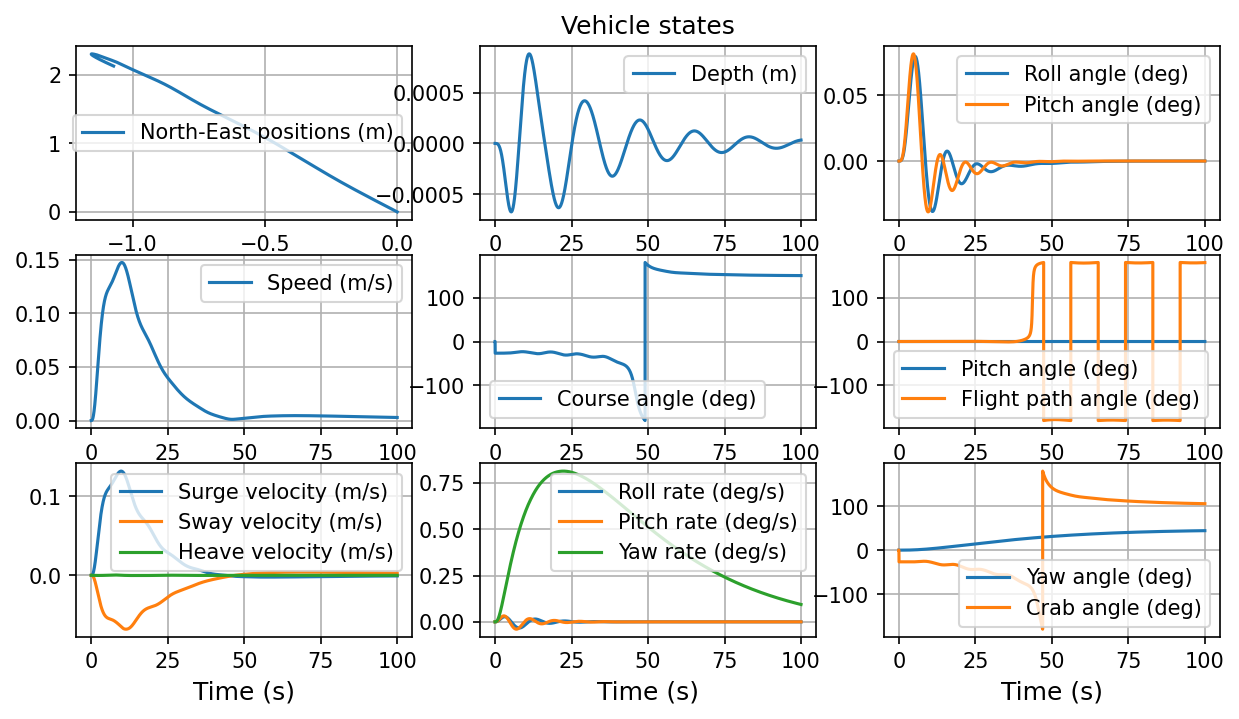

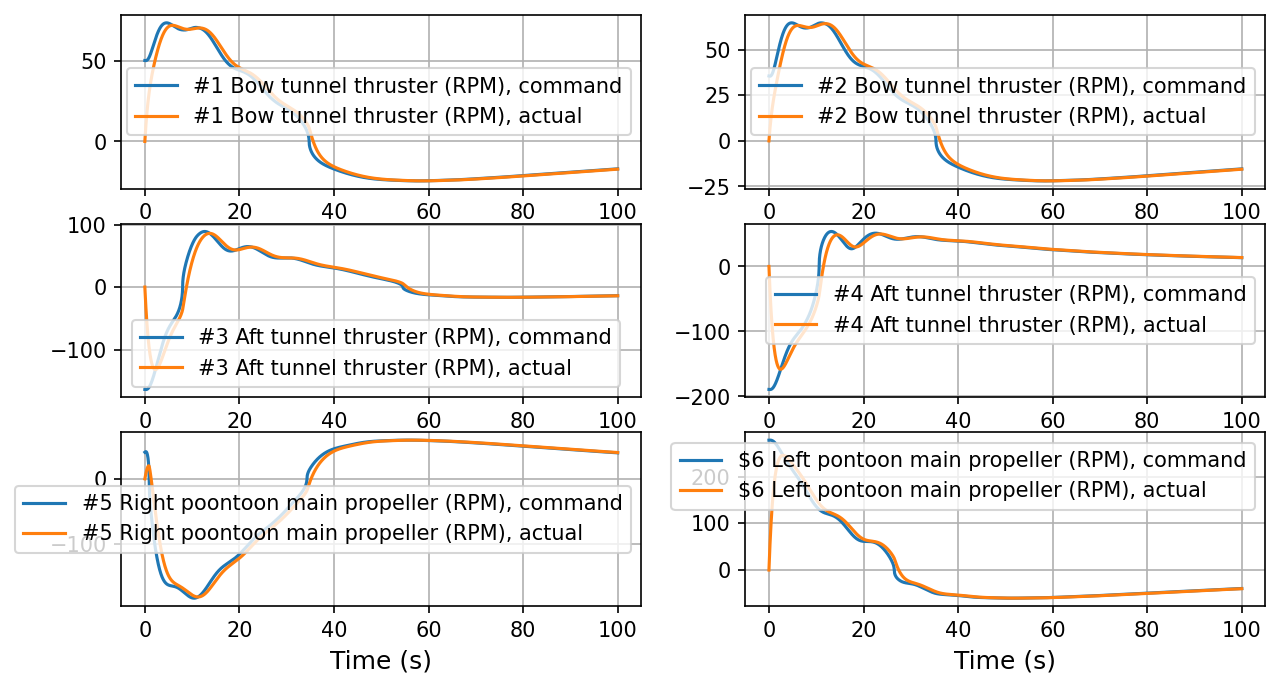

In [124]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [125]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

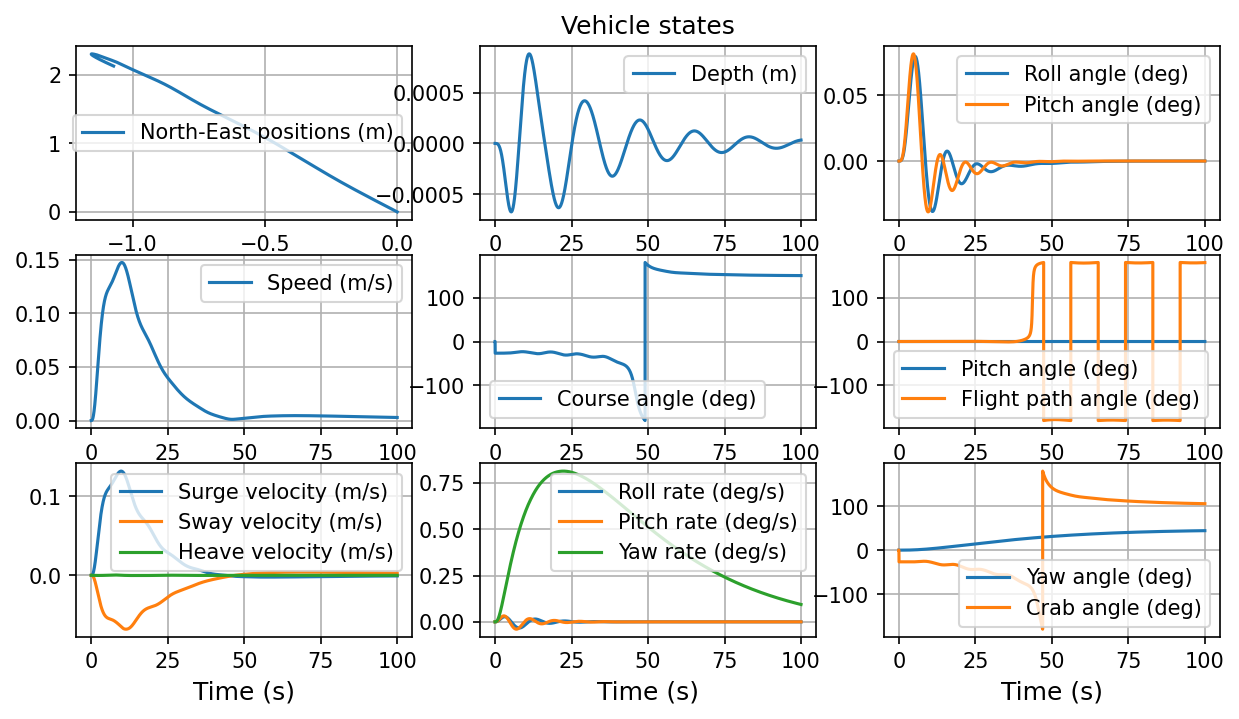

In [126]:
plotVehicleStates(simTime, simData, 3)

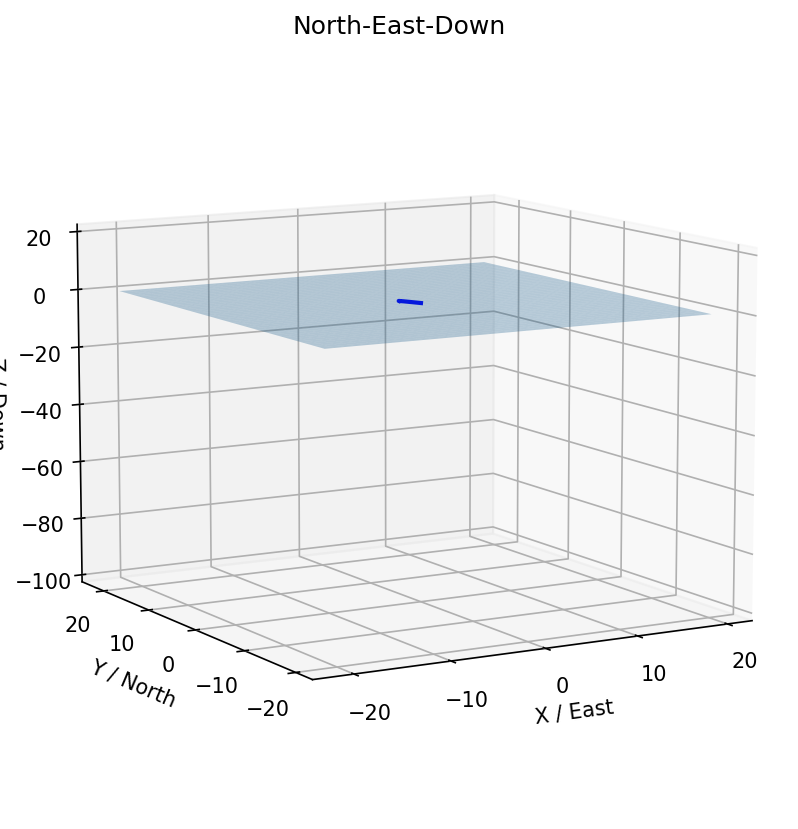

In [127]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [128]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [129]:
idx=1/0.01

In [130]:
idx

100.0

In [131]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [132]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [133]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [134]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [135]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [136]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [168]:
def grayscott1d(t, Q, coefs, T):

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = ssa(simData[:, 9][idx])
    q_ve = ssa(simData[:, 10][idx])
    r_ve = ssa(simData[:, 11][idx])


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

#     φ,θ,ψ=angle.T 
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [169]:
tspan = (0., 100)
T_ = MyTime()

In [170]:
coefs = [1, 1, 1, 1, 1, 1]

In [171]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  3.1484223583397536e-05  Iteration wall clock time:  0:00:01.389711
Physical time:  1.052510055735258  Iteration wall clock time:  0:00:07.505023
Physical time:  2.0935971753969542  Iteration wall clock time:  0:00:02.923210
Physical time:  3.0218394108142763  Iteration wall clock time:  0:00:08.675113
Physical time:  4.0071349597712524  Iteration wall clock time:  0:00:04.056470
Physical time:  5.041064387524653  Iteration wall clock time:  0:00:04.844652
Physical time:  6.01051584566671  Iteration wall clock time:  0:00:04.568450
Physical time:  7.045139918411836  Iteration wall clock time:  0:00:04.733335
Physical time:  8.044140116452075  Iteration wall clock time:  0:00:03.213726
Physical time:  9.118719281567772  Iteration wall clock time:  0:00:03.452175
Physical time:  10.008729577643484  Iteration wall clock time:  0:00:03.361534
Physical time:  11.09820954549636  Iteration wall clock time:  0:00:03.217789
Physical time:  12.134711724717508  Iteration wall clock

### Results

In [172]:
fin=us

In [173]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.148e-03 ...  9.662e+01  1.000e+02]
        y: [[ 0.000e+00  3.081e-15 ...  2.472e+00  2.568e+00]
            [ 1.210e+02  1.210e+02 ...  1.210e+02  1.210e+02]
            ...
            [ 0.000e+00 -1.381e-05 ...  8.412e-04 -1.054e-03]
            [ 0.000e+00 -1.540e-05 ...  9.087e-04 -1.141e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 368
     njev: 0
      nlu: 0

In [174]:
t=fin.t

In [175]:
fin=fin.y.T

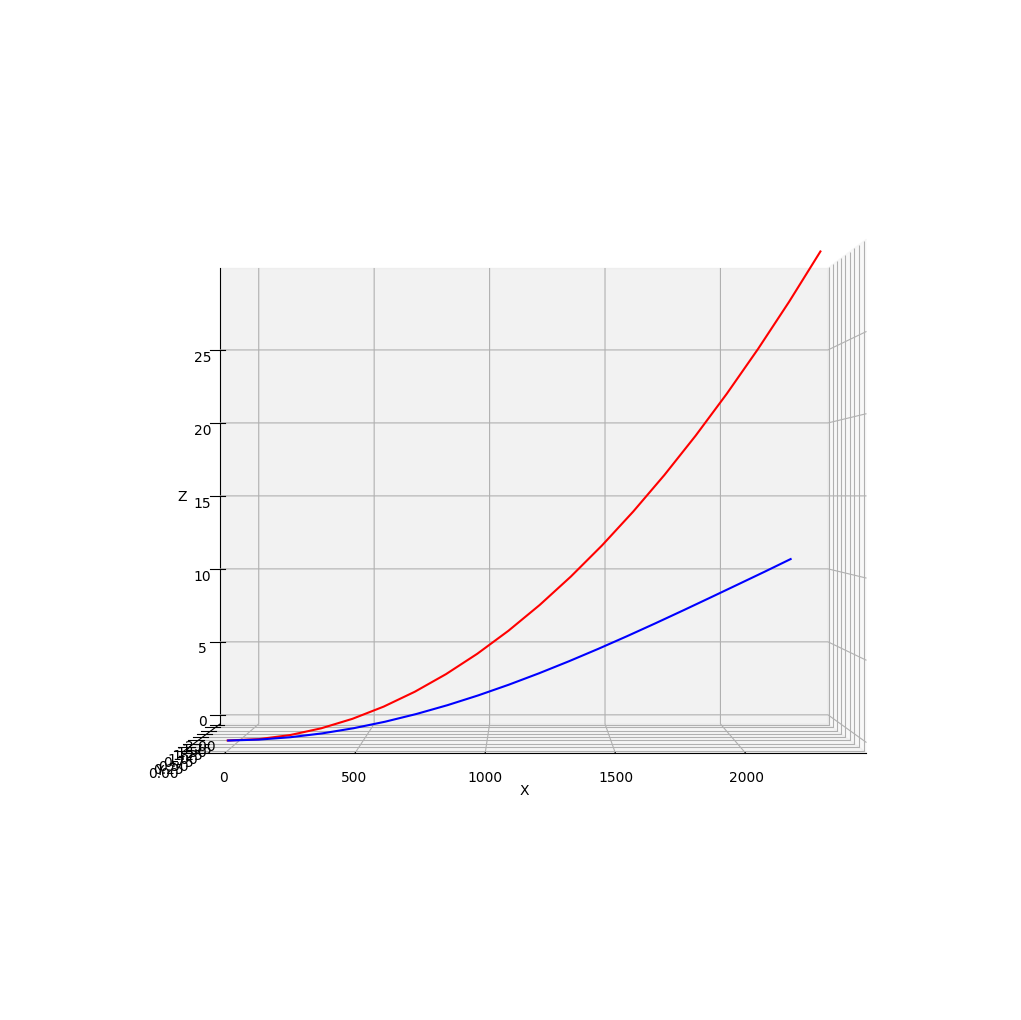

In [176]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [177]:
X,Y,Z

(array([   2.56782284,  120.96554216,  241.93111173,  362.89668959,
         483.86227698,  604.82787568,  725.79348802,  846.75911683,
         967.72476546, 1088.6904377 , 1209.65613783, 1330.62187054,
        1451.58764093, 1572.55345449, 1693.51931708, 1814.48523495,
        1935.45121465, 2056.41726309, 2177.38338751, 2295.7672291 ]),
 array([-0.0056653 ,  0.00592218,  0.03079259,  0.06839723,  0.1184189 ,
         0.18042432,  0.25387538,  0.33814296,  0.43252227,  0.53624942,
         0.64851812,  0.76849623,  0.89534128,  1.02821473,  1.16629464,
         1.30878634,  1.45493129,  1.60401393,  1.75536674,  1.90802732]),
 array([2.34590366e-03, 5.00256110e-02, 1.74737274e-01, 3.77320329e-01,
        6.56146371e-01, 1.00851743e+00, 1.43076232e+00, 1.91835964e+00,
        2.46608042e+00, 3.06814262e+00, 3.71836989e+00, 4.41034739e+00,
        5.13756880e+00, 5.89356945e+00, 6.67204250e+00, 7.46693587e+00,
        8.27252947e+00, 9.08349290e+00, 9.89492491e+00, 1.07032690e+01]))

In [178]:
X0,Y0,Z0

(array([   0.        ,  120.9655595 ,  241.93111899,  362.89667849,
         483.86223798,  604.82779748,  725.79335697,  846.75891647,
         967.72447596, 1088.69003546, 1209.65559495, 1330.62115445,
        1451.58671394, 1572.55227344, 1693.51783294, 1814.48339243,
        1935.44895193, 2056.41451142, 2177.38007092, 2298.34563041]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.08306948,  0.33227809,  0.74762628,  1.32911485,
         2.0767449 ,  2.99051782,  4.07043536,  5.31649953,  6.7287127 ,
         8.30707753, 10.05159699, 11.96227438, 14.0391133 , 16.28211766,
        18.69129171, 21.26663997, 24.00816732, 26.91587892, 29.98978026]))

In [179]:
us=fin.T

In [180]:
us.shape

(240, 58)

In [181]:
12*50

600

In [182]:
us.T[:,4*node_N+49]

array([ 0.00000000e+00,  1.07129832e-14,  1.27004596e-12,  6.35932895e-11,
       -2.63995373e-09, -1.04602274e-08, -2.22951259e-08, -3.55875368e-08,
       -4.89851855e-08, -6.19610910e-08, -7.42979501e-08, -8.58561411e-08,
       -9.64948799e-08, -1.06053785e-07, -1.14362130e-07, -1.21263498e-07,
       -1.26651487e-07, -1.30510235e-07, -1.32951931e-07, -1.34245354e-07,
       -1.34835433e-07, -1.35360706e-07, -1.36678667e-07, -1.39906376e-07,
       -1.46473579e-07, -1.58161988e-07, -1.77055064e-07, -2.05235272e-07,
       -2.44039588e-07, -2.92927037e-07, -3.48630254e-07, -4.05238336e-07,
       -4.54193903e-07, -4.85474510e-07, -4.93287586e-07, -4.89852626e-07,
       -5.14991543e-07, -6.16998358e-07, -7.53768873e-07, -7.97027550e-07,
       -7.80729893e-07, -7.81990348e-07, -8.90930845e-07, -1.04531269e-06,
       -1.13971223e-06, -1.13437166e-06, -1.10089655e-06, -1.16891944e-06,
       -1.32491242e-06, -1.44104376e-06, -1.44133967e-06, -1.37446954e-06,
       -1.39939426e-06, -

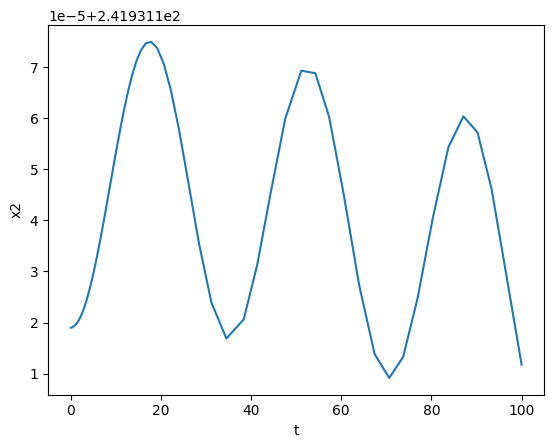

In [183]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

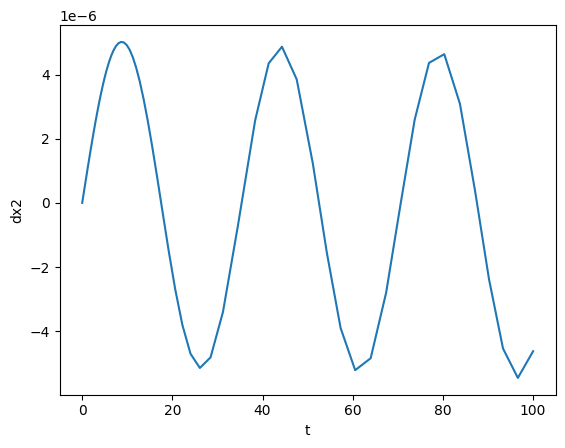

In [184]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

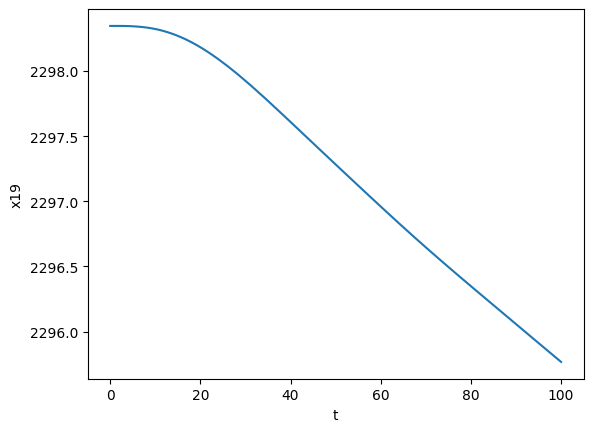

In [185]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

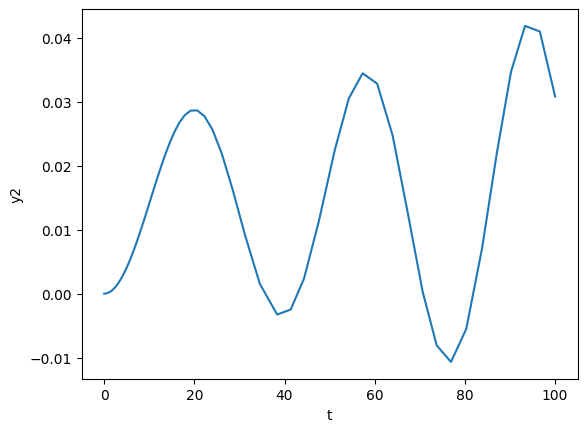

In [186]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

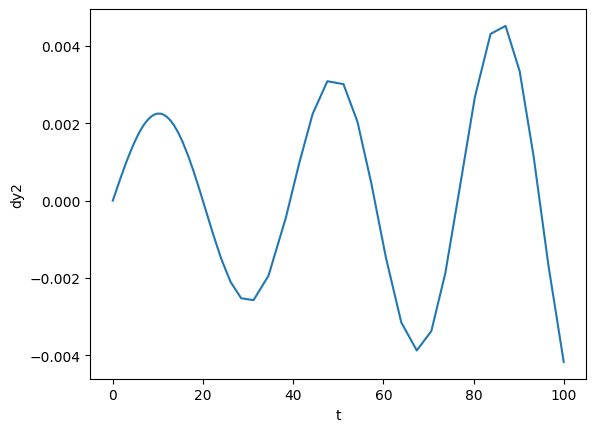

In [187]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

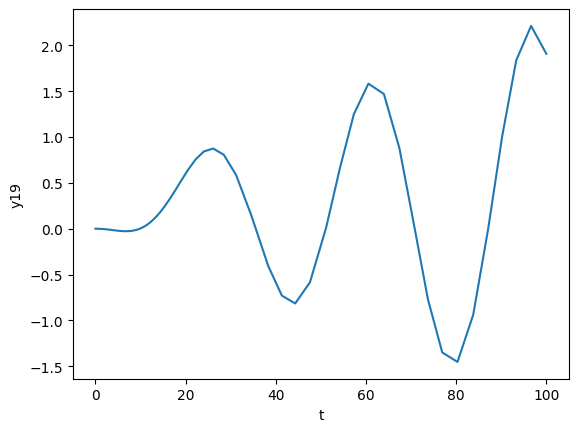

In [188]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

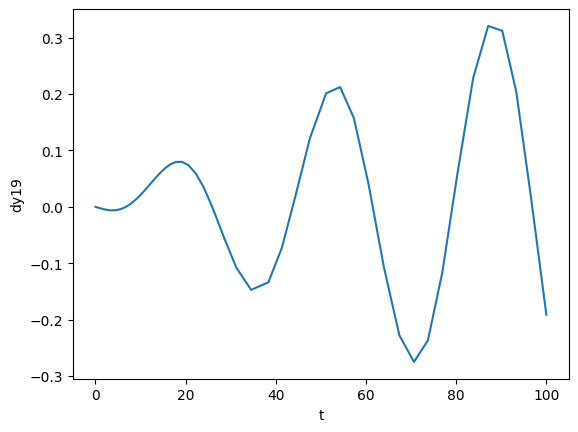

In [189]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

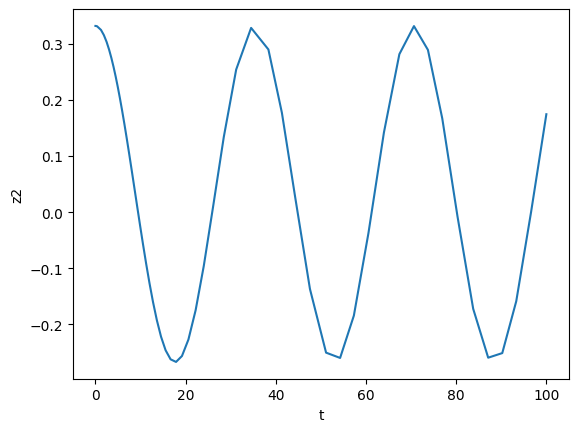

In [190]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

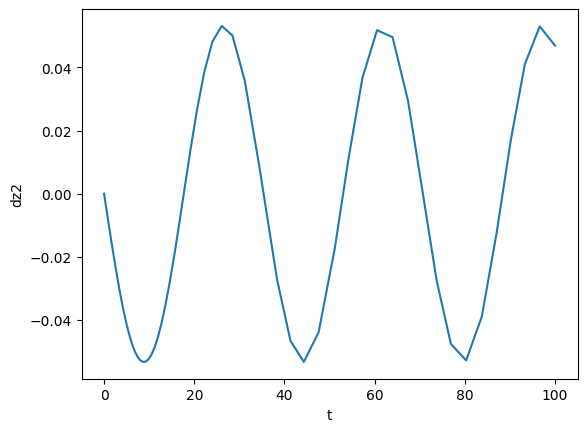

In [191]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

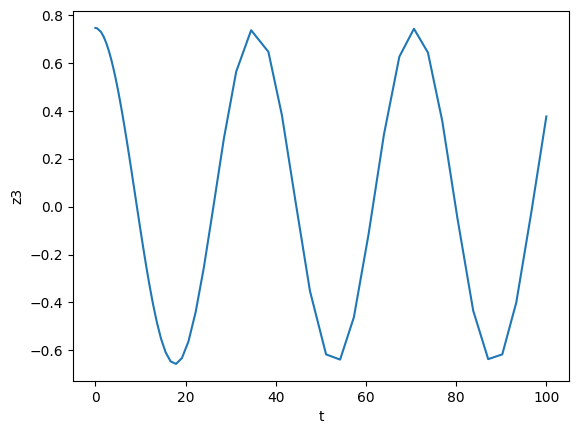

In [192]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

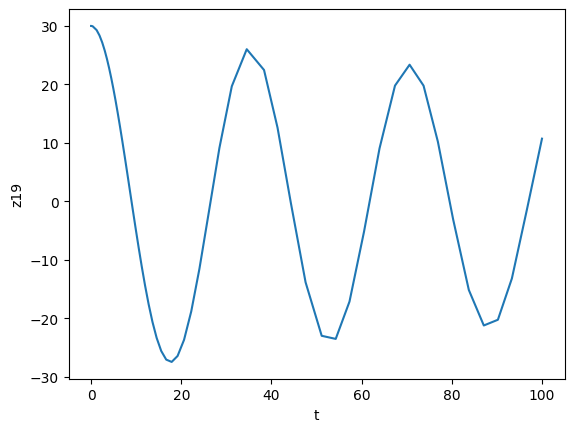

In [193]:
plt.plot(t,us.T[:,4*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

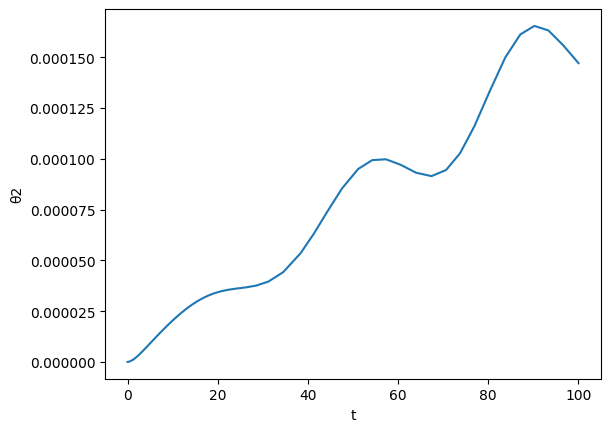

In [194]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

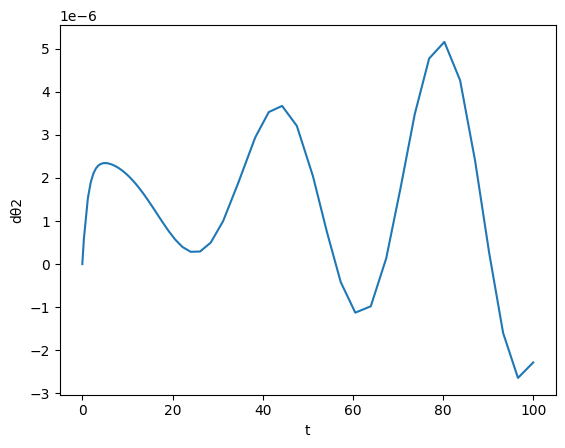

In [195]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

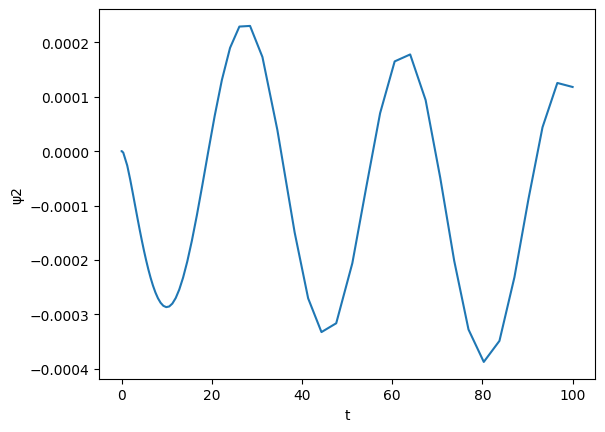

In [196]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

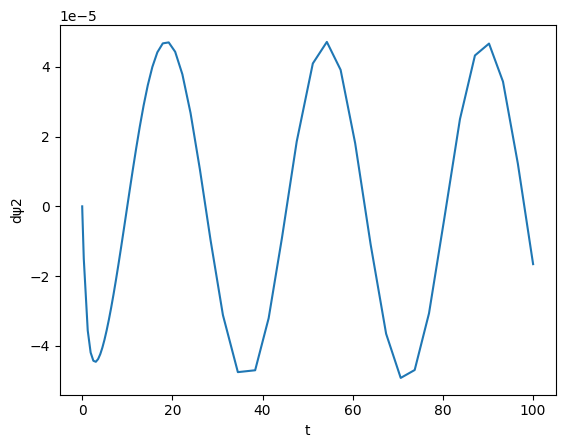

In [197]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

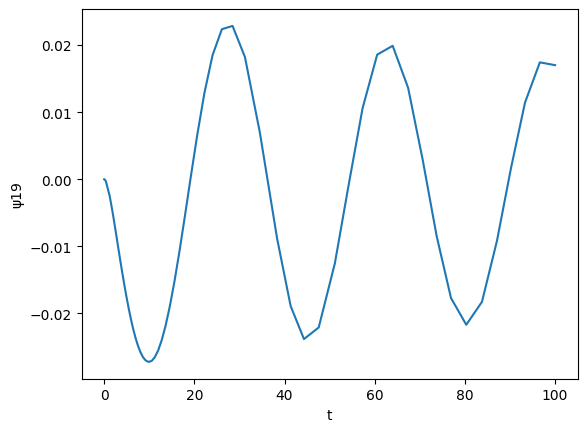

In [198]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()